# Grand Central Terminal - Trajectories
    author: Patricia Ternes
    created: 01/10/2020
    

This notebook presents the real data obtained from a video sequence, recorded at Grand Central Terminal (GCT). 

The raw data was processed and analyzed. The main steps of this process, together with the main results are presented below.

## Source of real data

The raw real data is available in two formats: 
* Video (AVI file): the original video is a 33:20-minutes video sequence shoot at 25fps with a resolution of 720x480.
* Trajectories (mat file): the trajectories were determined through a KLT keypoint tracker on GCT video.

Both, video and trajectories are available on the [Xiaogang Wang's Home Page](http://www.ee.cuhk.edu.hk/~xgwang/grandcentral.html).

## Raw data: reading and transforming

To start the real data analizys, we are use the trajectories mat file (<i>gcs_real_trajectories.mat</i>)

### Reading the trajectories

In [2]:
from scipy.io import loadmat

#open and read original file
file_name = "gcs_real_trajectories.mat"
file = loadmat(file_name)
trajectories = file["trks"][0]

The trajectories will be reorganized in a list called "data". Each line in this list will have 4 elements: pedestrian ID, position  𝑥 , position  𝑦 , and time.

In [3]:
data = []
for i in range (len(trajectories)):
    x, y, t = trajectories[i]
    x, y, t = x.flatten(), y.flatten(), t.flatten()
    for j in range (len(x)):
        values = [i, x[j], y[j], t[j]]  # indices: ['pedestrianID', 'x', 'y', 'time']
        data.append(values)

### Sort by frame and by pedestrian

The list "data" can be organized in different ways. Here, the "data" is organized by frame (data1) and by pedestrian (data2).


In [6]:
from operator import itemgetter

#sort by frame
data1 = sorted(data, key=itemgetter(3))
n_frame =  data1[-1][3] + 1
print('Number of frames: ', n_frame)

#sort by pedestrian
data2 = sorted(data, key=itemgetter(0))
n_pedestrian = data1[-1][0] + 1
print('Number of pedestrians: ', n_pedestrian)

Number of frames:  50010
Number of pedestrians:  42821


### Trails without treatment

To get an overview of the data, some trajectories are plotted below. Note that the visualization is upside down. Also note that the trajectories on the sides are not parallel to the $y$-axis.

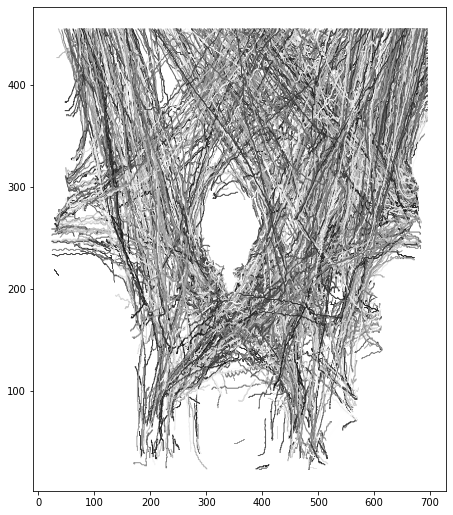

In [11]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(num=None, figsize=(7.4, 8.9), facecolor='w', edgecolor='k')

agent = 0
x , y = [], []
for i in range (500000):
        if (data2[i][0] == agent):
            x.append(data2[i][1])
            y.append(data2[i][2])
        else:
            gray_scale = np.random.uniform(0.1,1)
            plt.plot (x, y, '-', lw=1, color=str(gray_scale))
            agent += 1
            x , y = [], []
            x.append(data2[i][1])
            y.append(data2[i][2])

### Transforming the data

The raw trajectories are in the perspective of the camera that was positioned a quarter way up the concourse from the East Balcony. 

These trajectories therefore need to be transformed so that they represent the locations of the pedestrians on a regular two-dimensional space.

Due to a lack of information regarding the camera's exact position and field of view, a standard perspective transform did not yield adequate results because either the near camera trajectories tended towards the camera, or the trajectories did not represent the expected dimensions. 

Therefore, we assume that the distortion in the horizontal and vertical directions are proportional to the distance in the camera direction (vertical direction). Taking the height of the unprocessed image to be $h'$, the transformations are given as:

$$ x = x'(1 + \delta)\qquad\hbox{and}\qquad y = y'(1 + \delta),$$

where $\delta = y'/h'$ is the ratio distortion, $x'$ and $y'$ are the horizontal and vertical position of the pedestrian before transformation, and $x$ and $y$ are the horizontal and vertical position of the pedestrian after transformation.

In [12]:
from operator import itemgetter

data3 = [] # transformed data

for i in range (len(data)):
    data[i][2] = -1.* data[i][2] + 455.   # correct upside down
    data3.append(data[i])
    ratio = data[i][2]/431
    data3[i][1] = data[i][1]-347.5 #centre x axis to camera
    data3[i][1] = data3[i][1] * (1 + ratio)  + 355.1403712296984 # new x position
    data3[i][2] = data[i][2] * (1 + ratio)  # new y position

#sort by frame
data1 = sorted(data3, key=itemgetter(3))

#sort by pedestrian
data2 = sorted(data3, key=itemgetter(0))

To obtain an overview of the data, some transformed trajectories are plotted below. Note that the view is no longer upside down. Also note that the vertical paths are now parallel to the y axis.

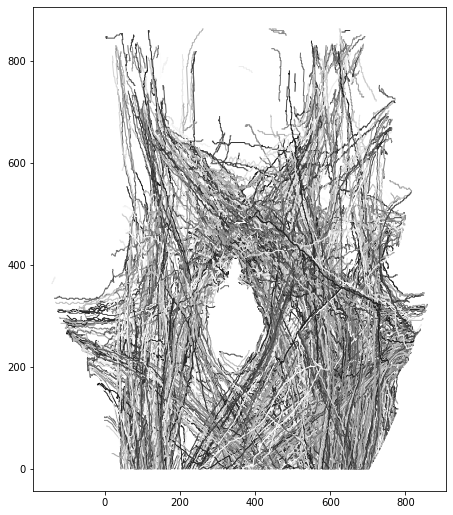

In [13]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(num=None, figsize=(7.4, 8.9), facecolor='w', edgecolor='k')

agent = 0
x , y = [], []
for i in range (500000):
        if (data2[i][0] == agent):
            x.append(data2[i][1])
            y.append(data2[i][2])
        else:
            gray_scale = np.random.uniform(0.1,1)
            plt.plot (x, y, '-', lw=1, color=str(gray_scale))
            agent += 1
            x , y = [], []
            x.append(data2[i][1])
            y.append(data2[i][2])

## Main characteristics of GCT

* environment size
* clock location and size
* gates location and width;

Using the trajectories as references we will determine the position of the walls and other structures of the station. In the next figure on the left, elements consistent with the real GCT structure have been incorporated into the graph. The red dashed line separate the camera's field of view from non-visible region. Only the visible region will be simulated, and the figure on the right shows the version of the station adapted for use in the StationSim_gcs model. Some pseudo-real gates (gates from 7 to 10) are created to demarcate the pedestrian entry and exit regions when the agents cross the line that separates the visible region from the non-visible region.

The structures dimentions are in pixel. For this data, to transform from pixel to metre:

$$1\hbox{ metre} = 14 \hbox{ pixel}$$

Text(0, 0.5, 'Height (pixel)')

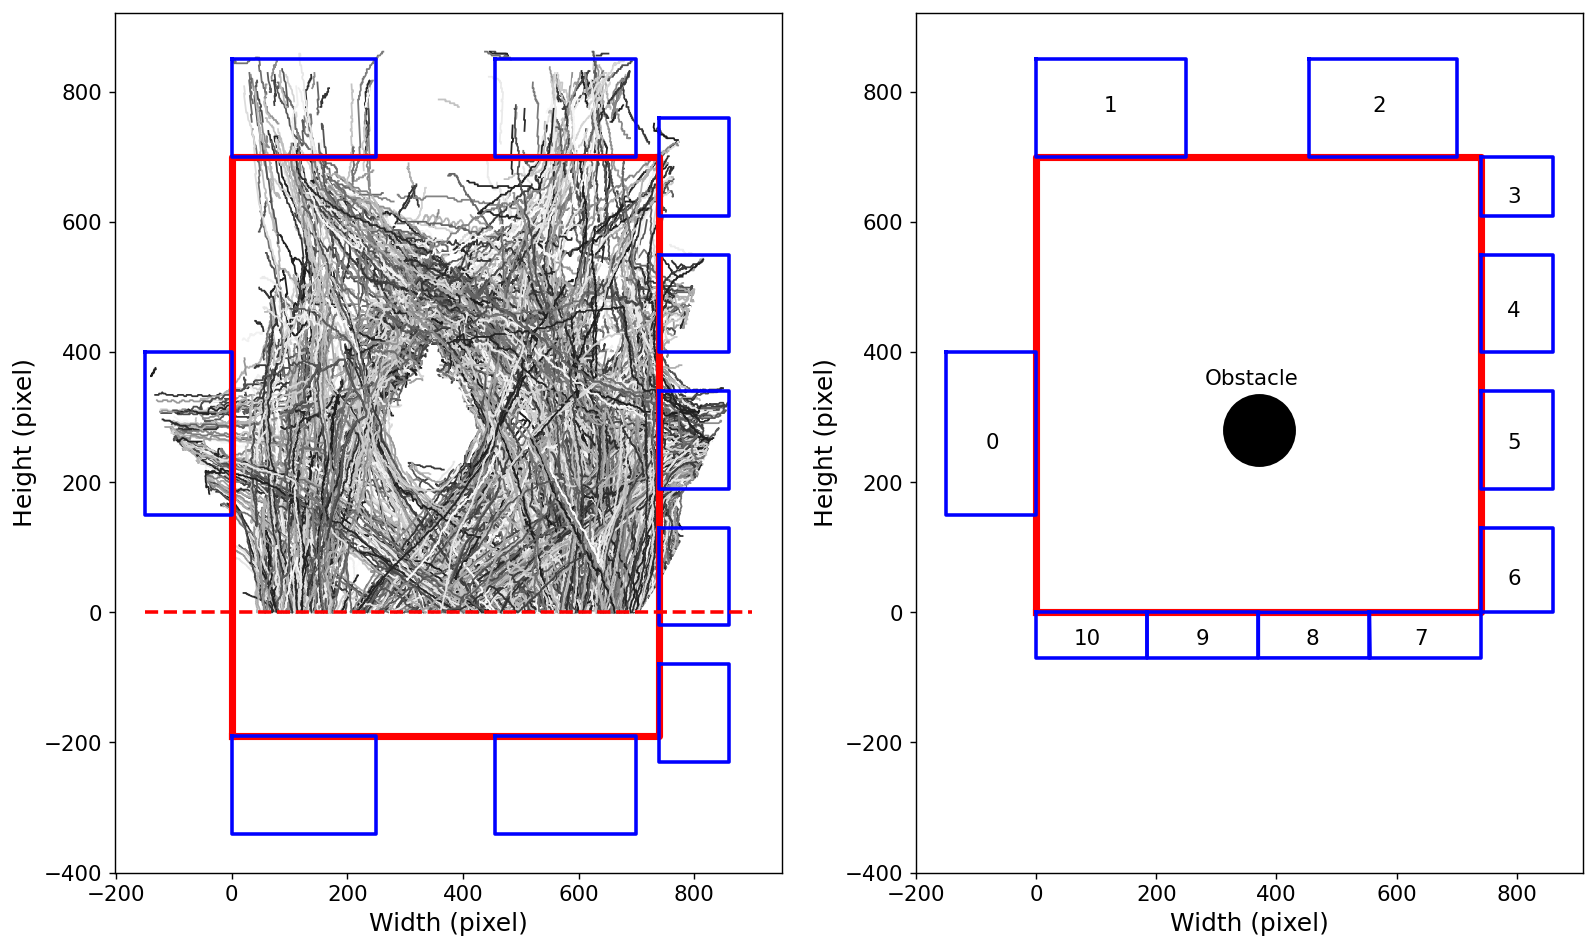

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(num=None, figsize=(14.8, 8.9), dpi=128, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2, sharey=ax1)


agent = 0
x , y = [], []
for i in range (500000):
        if (data2[i][0] == agent):
            x.append(data2[i][1])
            y.append(data2[i][2])
        else:
            gray_scale = np.random.uniform(0.1,1)
            ax1.plot (x, y, '-', lw=1, color=str(gray_scale))
            agent += 1
            x , y = [], []
            x.append(data2[i][1])
            y.append(data2[i][2])

# plotting the station walls
a = [0, 0, 740, 740, 0]; b = [-190, 700, 700, -190, -190]; ax1.plot(a,b,'-', linewidth=4,color='r')
a = [0, 0, 740, 740, 0]; b = [0, 700, 700, 0, 0]; ax2.plot(a,b,'-', linewidth=4,color='r')

# plotting the station gate 0
a = [-150, 0, 0, -150, -150]; b = [400, 400, 150, 150, 400]; ax1.plot(a,b,'-', linewidth=2,color='b')
ax2.plot(a, b,'-',linewidth=2,color='b'); ax2.text(-84, 252, '0', fontsize=12)

# plotting the station gate 1
a = [0, 250, 250, 0, 0]; b = [850, 850, 700, 700, 850]; ax1.plot(a,b,'-', linewidth=2,color='b')
ax2.plot(a, b,'-',linewidth=2,color='b'); ax2.text(112, 770, '1', fontsize=12)

# plotting the station gate 2
a = [455, 700, 700, 455, 455]; b = [850, 850, 700, 700, 850]; ax1.plot(a,b,'-', linewidth=2,color='b')
ax2.plot(a, b,'-',linewidth=2,color='b'); ax2.text(560, 770, '2', fontsize=12)

# plotting the station gate 3
a = [740, 860, 860, 740, 740]; b = [760, 760, 610, 610, 760]; ax1.plot(a,b,'-', linewidth=2,color='b') 
b = [700, 700, 610, 610, 700]; ax2.plot(a, b,'-',linewidth=2,color='b'); ax2.text(784, 630, '3', fontsize=12)

# plotting the station gate 4
a = [740, 860, 860, 740, 740]; b = [550, 550, 400, 400, 550]; ax1.plot(a,b,'-', linewidth=2,color='b')
ax2.plot(a, b,'-',linewidth=2,color='b'); ax2.text(784, 455.0, '4', fontsize=12)

# plotting the station gate 5
a = [740, 860, 860, 740, 740]; b = [340, 340, 190, 190, 340]; ax1.plot(a,b,'-', linewidth=2,color='b')
ax2.plot(a, b,'-',linewidth=2,color='b'); ax2.text(784, 252, '5', fontsize=12)

# plotting the station gate 6
a = [740, 860, 860, 740, 740]; b = [130, 130, -20, -20, 130]; ax1.plot(a,b,'-', linewidth=2,color='b')
b = [130, 130, 0, 0, 130]; ax2.plot(a, b,'-',linewidth=2,color='b'); ax2.text(784, 42,  '6', fontsize=12)

# plotting the station gate 7_real
a = [740, 860, 860, 740, 740]; b = [-80, -80, -230, -230, -80]; ax1.plot(a,b,'-', linewidth=2,color='b')

# plotting the station gate 8_real
a = [455, 700, 700, 455, 455]; b = [-190, -190, -340, -340, -190]; ax1.plot(a,b,'-', linewidth=2,color='b')

# plotting the station gate 9_real
a = [0, 250, 250, 0, 0]; b = [-190, -190, -340, -340, -190]; ax1.plot(a,b,'-', linewidth=2,color='b')

# plotting the station gate 7
a = [555, 740, 740, 555, 555]; b = [0, 0, -70, -70, 0]; ax2.plot(a, b, linewidth=2,color='b')
ax2.text(630, -49.0, '7', fontsize=12)

# plotting the station gate 8
a = [370, 555, 556, 370, 370]; b = [0, 0, -70, -70, 0]; ax2.plot(a, b, linewidth=2,color='b')
ax2.text(448,-49, '8', fontsize=12)

# plotting the station gate 9
a = [185, 370, 370, 185, 185]; b = [0, 0, -70, -70, 0]; ax2.plot(a, b, linewidth=2,color='b')
ax2.text(266, -49.0, '9', fontsize=12)

# plotting the station gate 10
a = [0, 185, 185, 0, 0]; b = [0, 0, -70, -70, 0]; ax2.plot(a, b, linewidth=2,color='b')
ax2.text(63.0, -49.0, '10', fontsize=12)

# plotting view separation line plot ax1
a = [-150, 900]; b = [0, 0]; ax1.plot(a, b,'--', linewidth=2,color='r')

# plotting obstacle plot ax2
ax2.plot(371.0, 280, 'o' ,linewidth=2, color='k', ms = 40); ax2.text(280, 350, 'Obstacle', fontsize=12)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel("Width (pixel)", fontsize=14); ax1.set_ylabel("Height (pixel)", fontsize=14)
ax2.set_xlabel("Width (pixel)", fontsize=14); ax2.set_ylabel("Height (pixel)", fontsize=14)

#### Real environment parameters

|Parameter|Value|
|:----------|:-------------:|
|Main Concourse width |53 m|
|Main Concourse height | 64 m|
|Main Concourse height (visible area only) | 50 m|
|Obstacle radius | 4 m|
|Number of gates | 10|
|Number of gates (visible area only) | 7|

#### StationSim gates parameters
|Gate ID | Horizontal location (m) | Vertical location (m) | Width (m)
|:-------|:-------------|:-------------|:-------------|
|Gate 0  |  0.0 | 18.4  | 17.9 |
|Gate 1  |  8.9 | 50.0  | 17.9 |
|Gate 2  | 41.3 | 50.0  | 17.5 |
|Gate 3  | 52.9 | 46.8  | 6.4  |
|Gate 4  | 52.9 | 33.9  | 10.7 |
|Gate 5  | 52.9 | 265.0 | 10.7 |
|Gate 6  | 52.9 | 65.0  | 9.3  | 
|Gate 7  | 46.3 | 0.0   | 13.2 |
|Gate 8  | 33.0 | 0.0   | 13.2 |
|Gate 9  | 19.8 | 0.0   | 13.2 |
|Gate 10 | 6.6  | 0.0   | 13.2 |



##  Some analysis

### Number of pedestrian in each frame

Text(0.5, 0, 'Frame')

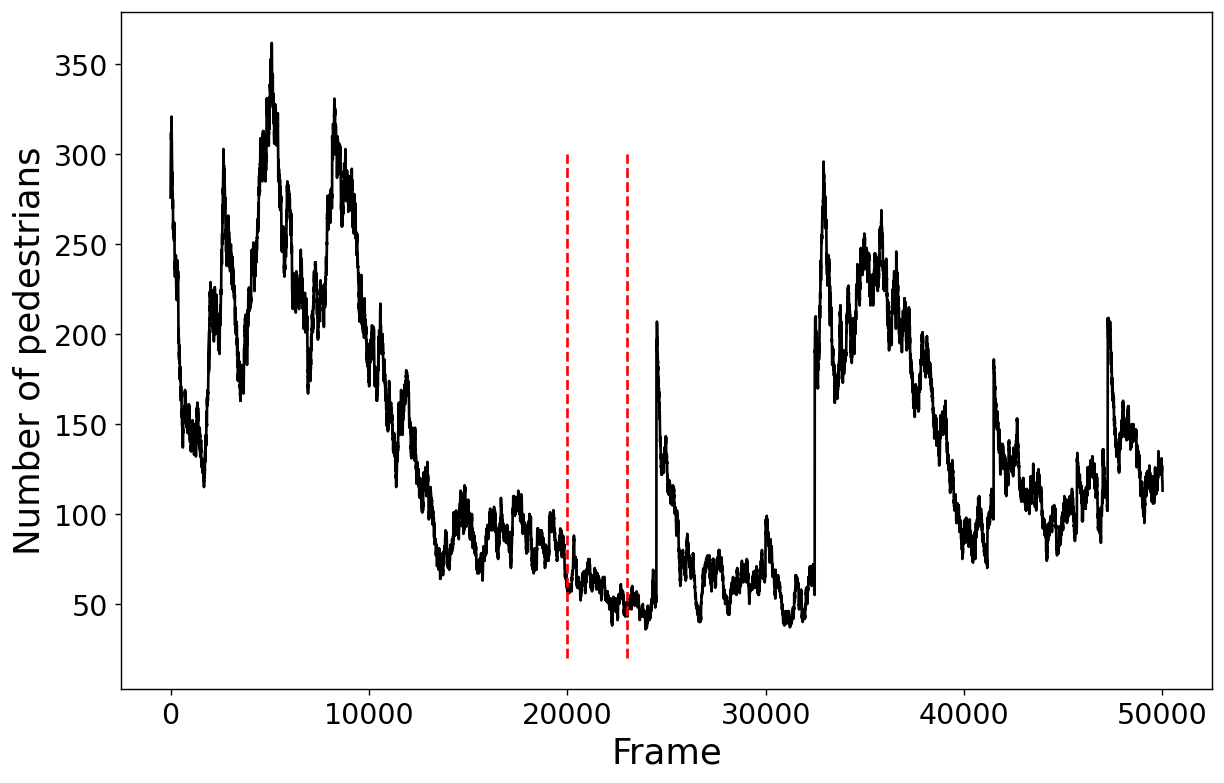

In [16]:
x = [i for i in range(1, n_frame-1, 1)]  #number of frames

y = [] #number of pedestrian

frame = 1
pID = [] #auxiliary list
for i in range (len(data1)):
    if (data1[i][3] == frame):
        pID.append(data2[i][0])
    else:
        y.append(len(pID))
        frame += 1
        pID = []
        pID.append(data2[i][0])

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')
ax1.plot (x, y,'-', color='k', ms=1)
    
a = [20000, 20000]
b = [20,300]
ax1.plot (a, b,'--', color='r', ms=1)
a = [23000, 23000]

ax1.plot (a, b,'--', color='r', ms=1)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel("Number of pedestrians", fontsize=20)
ax1.set_xlabel("Frame", fontsize=20)

This result shows that the number of pedestrians inside the station is not constant and can reach values around 350 pedestrians.

## Velocity of pedestrians

Three important parameters used to run the StationSim_gcs model are related with pedestrian speed:

* mean speed;
* standard deviation speed;
* minimum speed;

To obtain these parameters, a histogram is made with the pedestrian speeds and the parameters are obtained from a Gaussian fit.

The result is shown in pixel/frame (left) and in metre/second (right) where:

$$ 1 \dfrac{\hbox{pixel}}{\hbox{frame}} = \dfrac{25}{14} \dfrac{\hbox{metre}}{\hbox{second}}$$

Velocities in pixel/frame:
Adjusted Gaussian distribution with mean of  0.8719127839925644 pixel/frame
Adjusted Gaussian distribution with standard deviation of  0.31541650336123594 pixel/frame
Minimum speed:  0.030232558139534883 m/s 

Velocities in m/s:
Adjusted Gaussian distribution with mean of  1.5569871142724367 m/s
Adjusted Gaussian distribution with standard deviation of  0.5632437560022071 m/s
Minimun speed:  0.05398671096345515 m/s


Text(0, 0.5, 'Frequency')

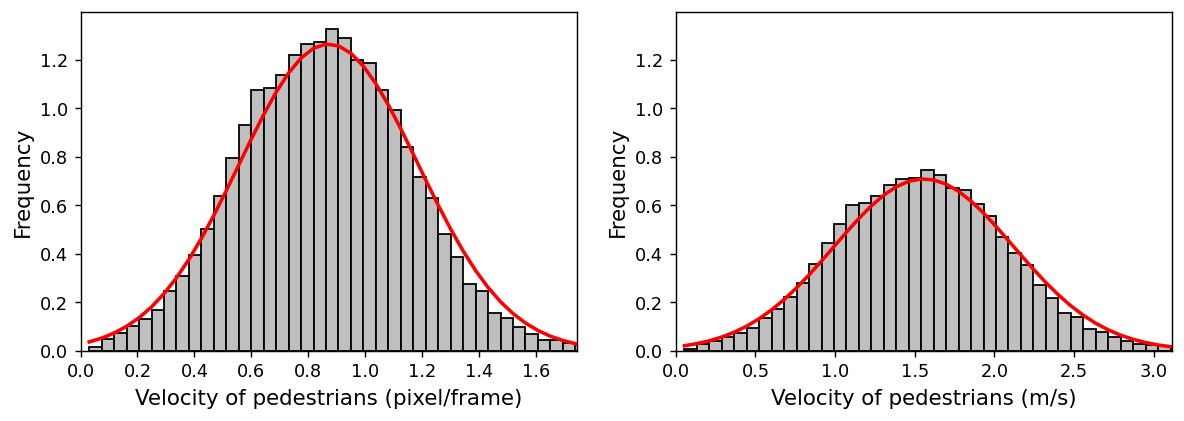

In [17]:
yy = []
transf = 25.0 / 14  # from (pixel/frame) to (m/s)

# getting speeds
agent = 0
x , y = [], []
for i in range (len(data2)):
    if (data2[i][0] == agent):
        x.append(data2[i][1])
        y.append(data2[i][2])
    else:
        deltaX = x[-1] - x[0]
        deltaY = y[-1] - y[0]           
        delta = np.sqrt(deltaX*deltaX + deltaY*deltaY)
        vel = delta / float(len(x))
        yy.append(vel)           
            
        agent += 1
        x , y = [], []
        x.append(data2[i][1])
        y.append(data2[i][2])
        
fig, ax = plt.subplots(num=None,figsize=(11, 3.5),dpi=128,facecolor='w',edgecolor='k',sharex='col',sharey='row')
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=True)

import math
n_bins = 20*math.ceil(max(yy) - min(yy))
n, bins, patches = ax1.hist(yy, bins=n_bins, density=True, color='0.75', edgecolor='k', lw = 1)

from scipy.stats import norm
import scipy.stats as scs
# determining fitting parameters
(mu, sigma) = norm.fit(yy)
ax1.set_xlim(0, 2.*mu) 

# plot adjusted normal distribution
y = scs.norm.pdf(bins, mu, sigma)
ax1.plot(bins, y, '-', color='r', lw = 2)

print('Velocities in pixel/frame:')
print('Adjusted Gaussian distribution with mean of ', mu, 'pixel/frame')
print('Adjusted Gaussian distribution with standard deviation of ', sigma, 'pixel/frame')
print('Minimum speed: ', min(yy), 'm/s \n')

yy = [yy[i]*transf for i in range(len(yy))]
n, bins, patches = ax2.hist(yy, bins=n_bins, density=True, color='0.75', edgecolor='k', lw = 1)

from scipy.stats import norm
import scipy.stats as scs
# determining fitting parameters
(mu, sigma) = norm.fit(yy)
ax2.set_xlim(0, 2.*mu) 

# plot adjusted normal distribution
y = scs.norm.pdf(bins, mu, sigma)
ax2.plot(bins, y, '-', color='r', lw = 2)
print('Velocities in m/s:')
print('Adjusted Gaussian distribution with mean of ', mu, 'm/s')
print('Adjusted Gaussian distribution with standard deviation of ', sigma, 'm/s')
print('Minimun speed: ', min(yy), 'm/s')


ax1.set_xlabel("Velocity of pedestrians (pixel/frame)", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax2.set_xlabel("Velocity of pedestrians (m/s)", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)

## Trajectory reconstruction process

The raw trajectories are highly fragmented with portions of missing observations; 

It is very rare for a single trajectory to capture the entirety of an individual's movement across the concourse. Therefore, it is necessary to join the trajectories of each pedestrian and fill in missing observations. The figure bellow shows a diagram of the trajectory reconstruction process.

![Reconstruction process diagram](process-diagram.png)

Briefly, to unify the parts of a pedestrian's trajectories we: 

1. identify a new trajectory that started right after the end of the previous trajectory; 
2. select the trajectory whose direction of movement is more consistent with the previous stretch; 
3. fill the gap between trajectories with a linear movement; and 
4. the initial/end of the trajectories of these pedestrians are created following a linear movement with speed and direction based on the observed part of the trajectory


The process involves creating and manipulating many files. In addition, until all trajectories are reconstructed, steps from i to iv are repeated several times.

After the trajectory reconstruction process, it was determined that, in total, 274 individuals appear in the selected video interval. Since the trajectory reconstruction process makes all trajectories complete, for these individuals all information is available: the time when each pedestrian entered in the station (*activation time*), the place of entry (*entrance gate*), the speed during each trajectory, and their final destination (*exit gate*).

At the end of this process, a [file](GCT_final_real_data/activation.dat) is generated with the parameters associated with each pedestrian and a [set of files](GCT_final_real_data/frames.tar.gz), one for each frame, with the prosition of each pedestrian present in the respective frame.

## Gates distribution

Although it is difficult to extract patterns for the entrance/exit gates, considering that 121 combinations are possible and we only have information from 274 individuals, two characteristics were observed in the processed data: 

1. no pedestrian leaves the station through the same gate that they enter; 
2. only about 1% of pedestrians leave the station through gates that are on the same side as the gate through which they entered.

The complete gates distribution is presented bellow:

![Gates distribution](gates_chart.png)